In [1]:
import dv_processing as dv
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_save_max_acc_refac

device = get_device()
dataset = 'davis'
total_time = 250
batch_size = 5
folder_name = 'FromLoihi_ABCXO_one_sample'

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  folder_name = folder_name)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

Running on: cuda:0
[ToFrame(sensor_size=(32, 32, 2), time_window=None, event_count=None, n_time_bins=250, n_event_bins=None, overlap=0, include_incomplete=False)]


In [2]:
dataset_dict['time_ms'] = 250
snn = SNN(dataset_dict=dataset_dict, structure=(24, 2, 'f'), tau_m=5.0, win=total_time, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.input2spike_th = 0.5

snn.set_layers()
snn.to(device)

Delta t: 1.0 ms
Delta t: 1.0 ms
Delta t: 1.0 ms


SNN(
  (criterion): MSELoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=2048, out_features=24, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=24, out_features=24, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=24, out_features=2, bias=False)
    )
  )
)

In [3]:
snn.debug = True
snn.init_state_logger()
a, b = snn.test(test_loader)

10
Test Loss: 0.47939999401569366
Avg spk_count per neuron for all 250 time-steps 199.1
Test Accuracy of the model on the test samples: 50.000



In [4]:
snn.spike_state.keys()

dict_keys(['input', 'l1', 'l2', 'output'])

In [5]:
i_spikes = snn.spike_state['input'].detach().cpu().numpy()
l1_spikes = snn.spike_state['l1'].detach().cpu().numpy()
l2_spikes = snn.spike_state['l2'].detach().cpu().numpy()
o_spikes = snn.spike_state['output'].detach().cpu().numpy()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

def plot_spikes(t):
    for x in range(batch_size):
        plt.figure(figsize=(10, 5))
        plt.suptitle(f"Timestep {t}, Sample {x}")
        plt.subplot(121)
        plt.imshow(i_spikes[t, x, :32*32].reshape(32, 32), aspect='auto')
        plt.subplot(122)
        plt.imshow(i_spikes[t, x, 32*32:].reshape(32, 32), aspect='auto')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.title(f"All Timesteps, Sample {x}")
        plt.imshow(i_spikes[:, x, :].T, aspect='auto')
        plt.show()

slider = widgets.IntSlider(value=75, min=0, max=i_spikes.shape[0]-1, step=1, description='Timestep')
widgets.interact(plot_spikes, t=slider)

interactive(children=(IntSlider(value=75, description='Timestep', max=249), Output()), _dom_classes=('widget-i…

<function __main__.plot_spikes(t)>

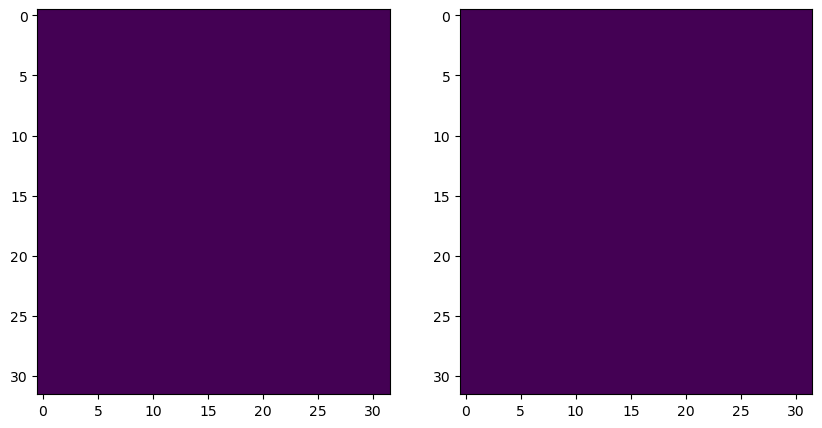

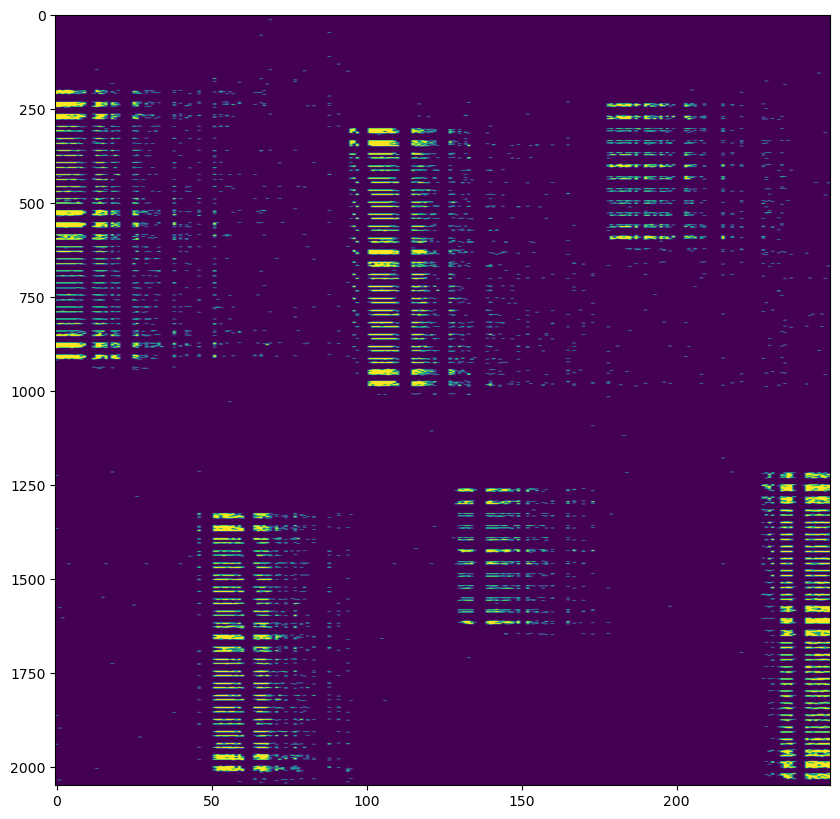

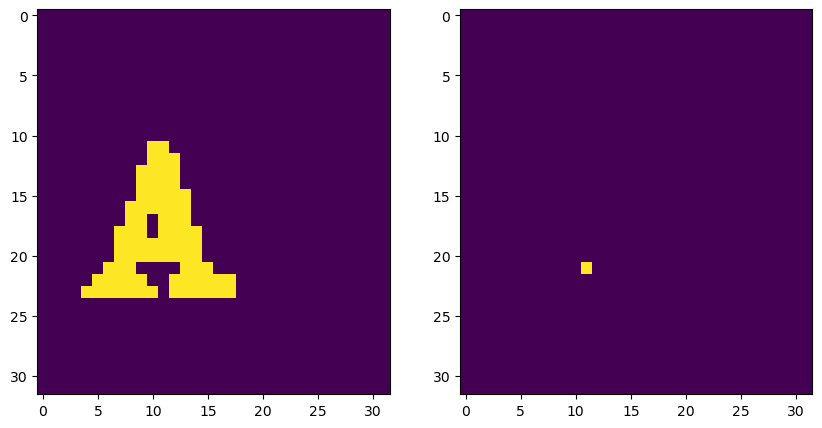

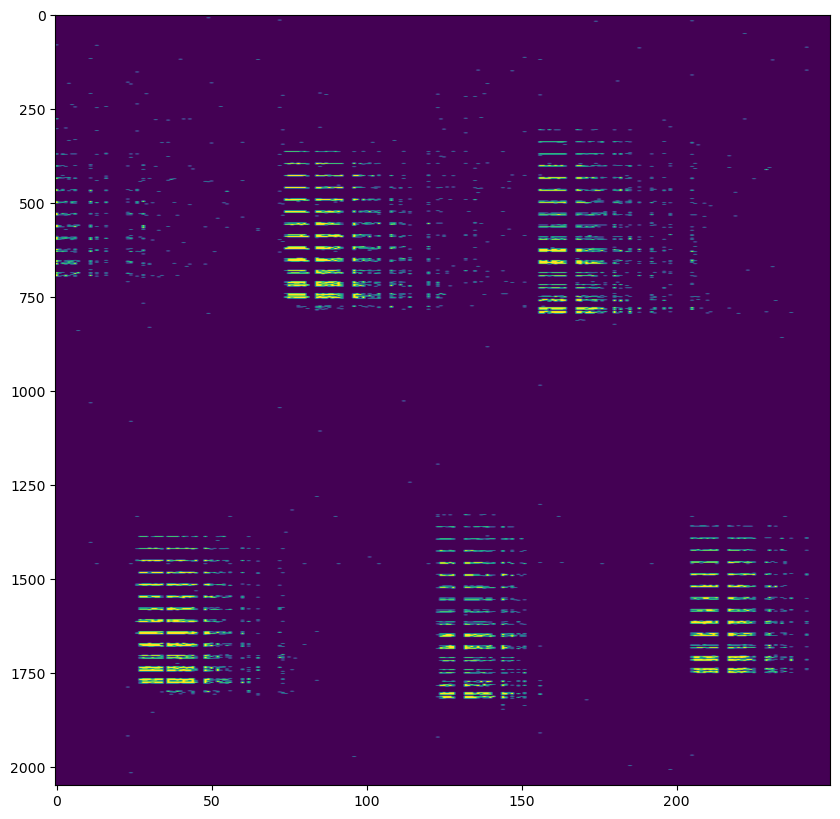

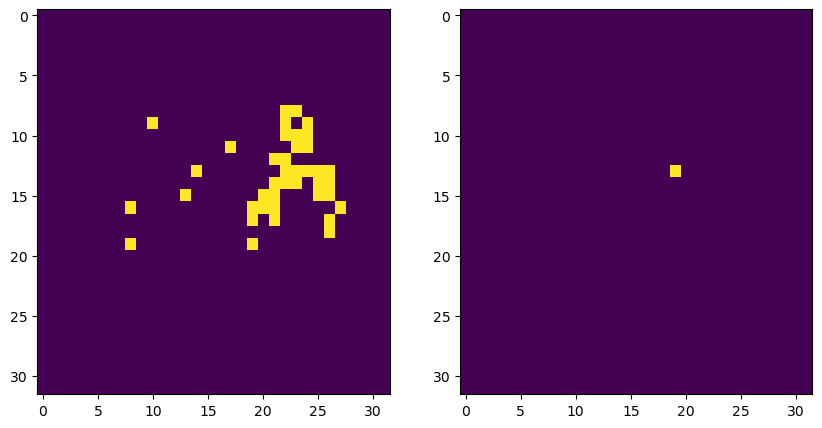

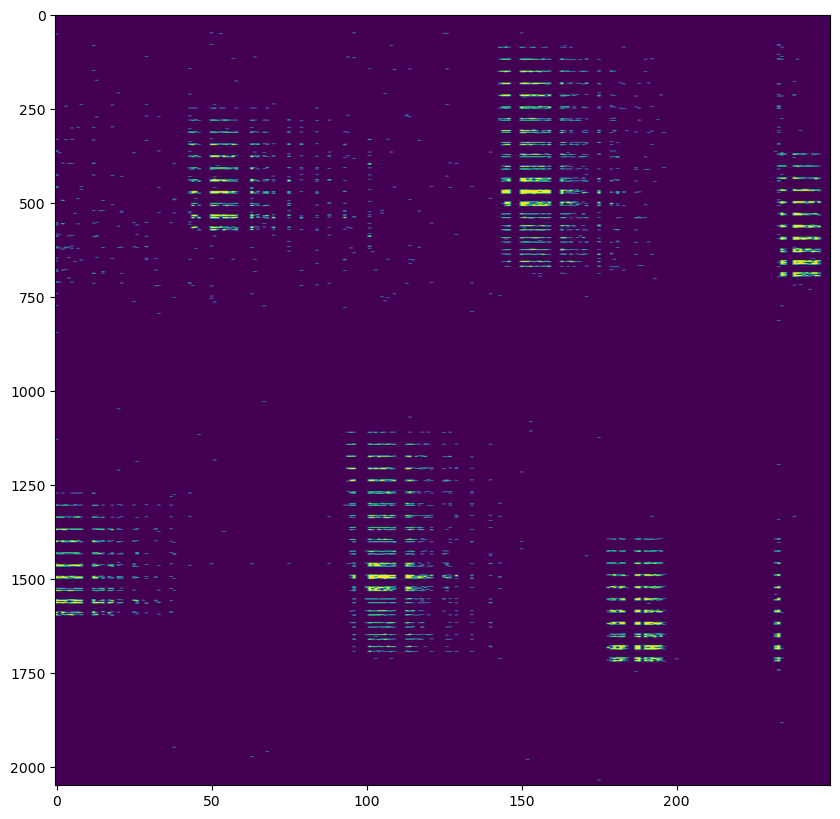

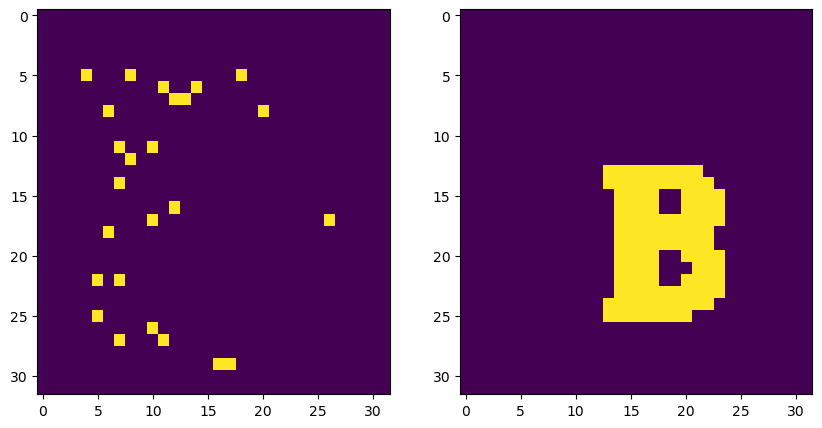

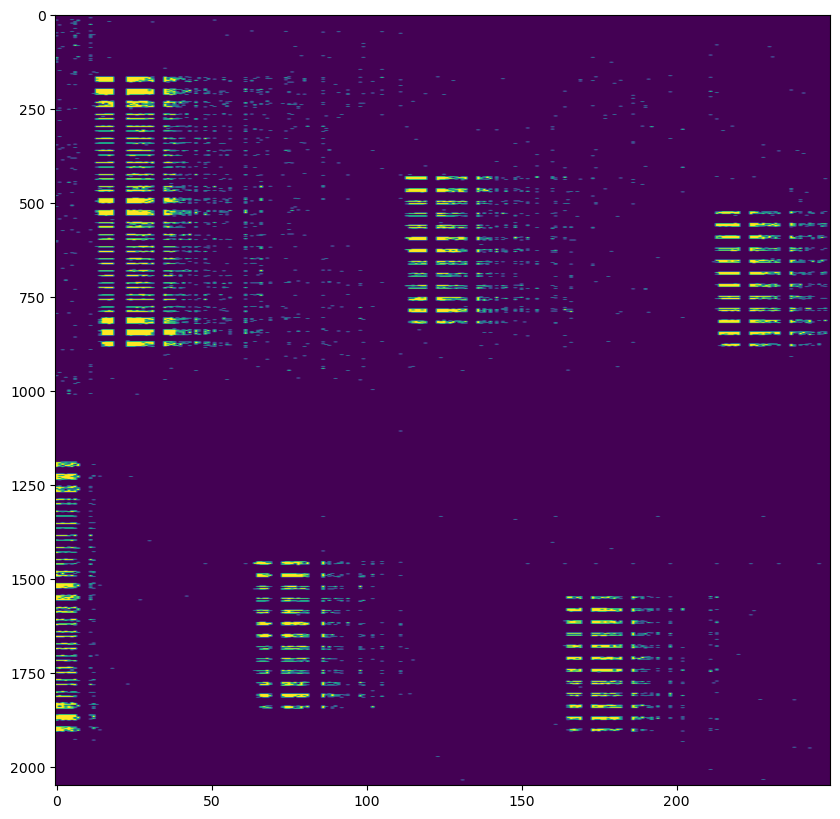

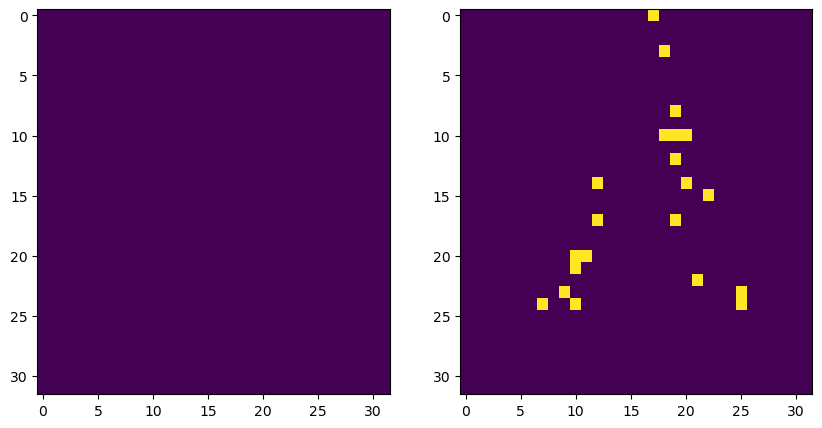

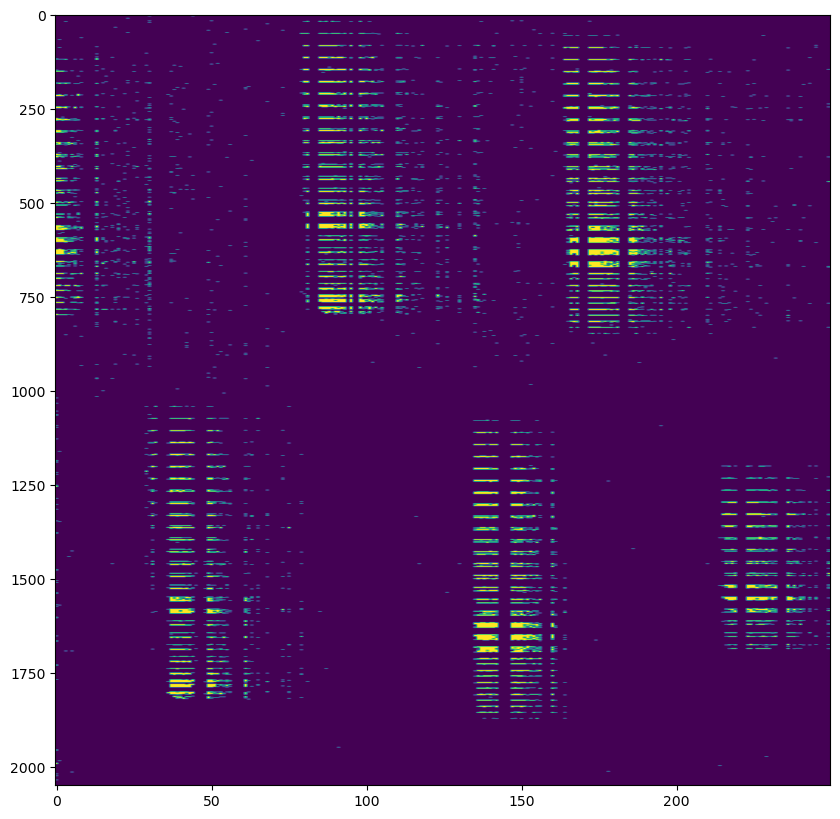

In [7]:
import matplotlib.pyplot as plt
import numpy as np
for x in range(batch_size):

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(i_spikes[75, x, :32*32].reshape(32, 32), aspect='auto')
    plt.subplot(122)
    plt.imshow(i_spikes[75, x, 32*32:].reshape(32, 32), aspect='auto')

    plt.figure(figsize=(10, 10))
    plt.imshow(i_spikes[:, x, :].T, aspect='auto')

    # plt.figure(figsize=(10, 5))
    # plt.imshow(l1_spikes[:, x, :].T, aspect='auto')

    # plt.figure(figsize=(10, 5))
    # plt.imshow(o_spikes[:, x, :].T, aspect='auto')

    #np.save(f'i_spikes_{x}.npy', i_spikes[:, x, :].T)